In [1]:

from google.colab import files


uploaded = files.upload()

Saving BERT_Preprocessed.csv to BERT_Preprocessed.csv


In [21]:
import pandas as pd
import io
df = pd.read_csv(io.BytesIO(uploaded['BERT_Preprocessed.csv']))

In [25]:
df = df.fillna("")

In [26]:
df.isnull().sum()

sentiment_class    0
cleaned_text       0
dtype: int64

In [27]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset

In [28]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(df['cleaned_text'], df['sentiment_class'], test_size=0.2, random_state=42)

In [29]:

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [30]:
# Convert input text to list of strings
train_texts = list(X_train)
val_texts = list(X_val)

# Tokenize input text using the BERT tokenizer
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128, return_tensors='pt')
val_encodings = tokenizer(list(X_val), truncation=True, padding=True, max_length=128, return_tensors='pt')

In [34]:
# Define a mapping for the categorical labels
label_map = {"positive": 2, "neutral": 1, "negative": 0}

# Convert categorical labels to numerical values
y_train_mapped = np.array([label_map[label] for label in y_train])
y_val_mapped = np.array([label_map[label] for label in y_val])

# Convert labels to PyTorch tensors
train_labels = torch.tensor(y_train_mapped, dtype=torch.long)
val_labels = torch.tensor(y_val_mapped, dtype=torch.long)


In [35]:
# Create DataLoader for training and validation data
train_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    train_labels
)
val_dataset = TensorDataset(
    val_encodings['input_ids'],
    val_encodings['attention_mask'],
    val_labels
)

In [36]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [37]:
# Initialize the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
# Define optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [39]:
# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [40]:
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    predictions = []
    true_labels = []
    for batch in val_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2]

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

        predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    print(f"Epoch {epoch + 1}, Accuracy: {accuracy}")


Epoch 1, Accuracy: 0.7602941176470588
Epoch 2, Accuracy: 0.7926470588235294
Epoch 3, Accuracy: 0.7794117647058824


In [41]:
# Define the file path for saving the model
output_model_path = 'bert_sentiment_model.pth'

# Save the entire model state
torch.save(model.state_dict(), output_model_path)

print("Model saved successfully!")

Model saved successfully!


In [48]:
# Tokenize validation data
val_encodings = tokenizer(list(X_val), truncation=True, padding=True, max_length=128, return_tensors='pt')
val_labels = torch.tensor(np.array([label_map[label] for label in y_val]), dtype=torch.long)

# Create DataLoader for validation data
val_dataset = TensorDataset(
    val_encodings['input_ids'],
    val_encodings['attention_mask'],
    val_labels
)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Initialize lists to store predictions and true labels
predictions = []
true_labels = []

# Set the model to evaluation mode
model.eval()

# Iterate over batches in the validation DataLoader
for batch in val_loader:
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2]

    # Perform forward pass to get model predictions
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    # Get predicted labels
    batch_predictions = torch.argmax(logits, dim=1).cpu().numpy()

    # Store predictions and true labels
    predictions.extend(batch_predictions)
    true_labels.extend(labels.cpu().numpy())

# Compute accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Validation Accuracy: {accuracy}")


Validation Accuracy: 0.7794117647058824


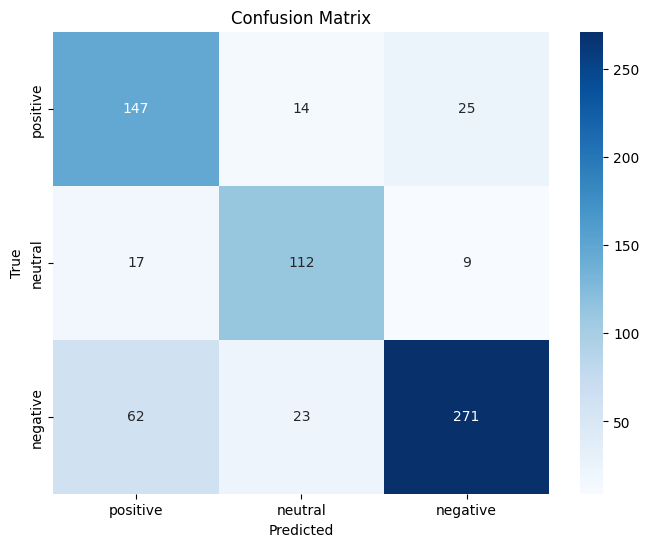

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()